# Optimising the Engine Model for Overlapping Audio

## Jessica Stinson
## s224576666

### Building the Model

The first half of this notebook defines the pipeline for building and saving the classification model. Previous versions of the Echo engine used multi-class classification, where each audio file was assigned a single species label. To address the challenge of overlapping animal vocalisations, this version adopts a multi-label classification approach. In this setup, multiple species can be predicted for each audio file. Label embeddings are used to encode species presence, enabling the model to better handle complex acoustic environments and providing greater flexibility for future expansion of species detection. The audio data directory for this model is composed of the original, single-species audio files as well as synthetic audio files containing a mix of two to three vocalisations. 

In [1]:
# Suppress warnings 
import warnings
warnings.filterwarnings("ignore")

# Set TensorFlow environment
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

# Standard libraries 
import datetime
import functools
from functools import lru_cache
import hashlib
import io
import json
import math
import random
import time
from pathlib import Path
from platform import python_version

# Data and numerical libraries 
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Audio handling 
import soundfile as sf
import librosa

# Machine learning
import tensorflow as tf
import tensorflow_hub as hub

# Audio augmentation
import audiomentations
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

# Caching
import diskcache as dc

# Metrics for multi-label evaluation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer

# Version info
print('Python Version           : ', python_version())
print('TensorFlow Version       : ', tf.__version__)
print('TensorFlow hub Version   : ', hub.__version__)
print('Librosa Version          : ', librosa.__version__)
print('Audiomentations Version  : ', audiomentations.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU detected: {gpus}")
else:
    print("No GPU detected, using CPU.")

Python Version           :  3.10.18
TensorFlow Version       :  2.10.0
TensorFlow hub Version   :  0.16.1
Librosa Version          :  0.11.0
Audiomentations Version  :  0.42.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Applying system constraints
SC = {
    'AUDIO_DATA_DIRECTORY': r"C:\Project-Echo\src\Prototypes\engine\Working with overlapping audio\Synthetic Dataset",    
    'CACHE_DIRECTORY': r"C:\Project-Echo\src\Prototypes\engine\Working with overlapping audio\cache",

    'AUDIO_CLIP_DURATION': 5, # seconds 
    'AUDIO_NFFT': 2048,
    'AUDIO_WINDOW': None,
    'AUDIO_STRIDE': 200,
    'AUDIO_SAMPLE_RATE': 48000,
    'AUDIO_MELS': 260,
    'AUDIO_FMIN': 20,
    'AUDIO_FMAX': 13000,
    'AUDIO_TOP_DB': 80,

    'MODEL_INPUT_IMAGE_WIDTH': 260,
    'MODEL_INPUT_IMAGE_HEIGHT': 260,
    'MODEL_INPUT_IMAGE_CHANNELS': 3,

    'USE_DISK_CACHE': True,
    'SAMPLE_VARIANTS': 20,
    'CLASSIFIER_BATCH_SIZE': 16,
    'MAX_EPOCHS': 100,
    'EMBEDDING_SIZE': 64
}

In [3]:
def enforce_memory_limit(mem_mb):
  gpus = tf.config.experimental.list_physical_devices('GPU')
  if gpus:
    try:
      tf.config.experimental.set_virtual_device_configuration(
          gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=mem_mb)])
      print(f"vram limit set to {mem_mb}MB")
    except RuntimeError as e:
      print(e)

In [4]:
if SC['USE_DISK_CACHE']:
    cache = dc.Cache(SC['CACHE_DIRECTORY'], cull_limit=0, size_limit=10**9) 

def create_function_key(func, *args, **kwargs):
    partial_func = functools.partial(func, *args, **kwargs)
    func_name = partial_func.func.__name__
    func_module = partial_func.func.__module__
    args_repr = repr(partial_func.args)
    kwargs_repr = repr(sorted(partial_func.keywords.items()))

    key = f"{func_module}.{func_name}:{args_repr}:{kwargs_repr}"
    # Use hashlib to create a hash of the key for shorter and consistent length
    key_hash = hashlib.sha256(key.encode()).hexdigest()

    return key, key_hash, partial_func

In [5]:
def paths_and_labels_to_dataset(audio_paths, labels, num_classes):
    labels_tensor = tf.convert_to_tensor(labels, dtype = tf.float32)
    
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels_tensor)

    zipped_path_ds = tf.data.Dataset.zip((path_ds, label_ds))
    
    return zipped_path_ds

embedding_dim = SC['EMBEDDING_SIZE']

def create_class_embeddings(class_names, embedding_dim=embedding_dim):
    """
    Creates a dictionary mapping each class name to a unique, randomly initialized embedding.
    """
    embeddings = {}
    random.seed(42)  
    for class_name in class_names:
        embeddings[class_name] = np.random.rand(embedding_dim).astype(np.float32)
    return embeddings

# Function to create the datasets
def create_datasets(audio_dir, train_split=0.8, val_split=0.19, split_file=None, save_splits_to=None):
    if split_file and os.path.exists(split_file):
        print("Loading dataset splits from saved file")
        with open(split_file, "r") as f:
            data = json.load(f)
        file_paths = data["file_paths"]
        labels = data["labels"] 
        class_names = data["class_names"]
        
        # Recreate embeddings from saved data
        class_embeddings = {name: np.array(emb, dtype=np.float32) for name, emb in data["class_embeddings"].items()}

        # Assign multi_labels for return
        multi_labels = np.array(labels)
        
        # Create multi-label embeddings by averaging individual embeddings
        multi_embeddings = []
        for file_labels in labels:
            file_embedding = np.zeros(embedding_dim, dtype=np.float32)
            for i, is_present in enumerate(file_labels):
                if is_present:
                    present_embeddings = [class_embeddings[class_names[i]] for i, 
                                          present in enumerate(file_labels) if present]
                    file_embedding = np.mean(present_embeddings, axis=0)

            multi_embeddings.append(file_embedding)
        multi_embeddings = np.array(multi_embeddings)
        
    else:
        print("Creating new dataset splits")
        # Load audio files from directory
        file_paths = sorted([str(p) for p in Path(audio_dir).glob('**/*') if p.suffix in ('.ogg', '.mp3', '.wav', '.flac')])

        # Load multi-hot labels from .npy file
        label_file_path = r"C:\Project-Echo\src\Prototypes\engine\Working with overlapping audio\Synthetic Dataset\synthetic_labels.npy"
        labels = np.load(label_file_path).tolist()

        if len(file_paths) != len(labels):
            raise ValueError(f"Number of files ({len(file_paths)}) does not match number of labels ({len(labels)})")

        with open(Path(audio_dir) / "class_names.json", "r") as f:
            class_names = json.load(f)
        
        all_data = list(zip(file_paths, labels))
        random.seed(42)
        random.shuffle(all_data)

        file_paths, multi_labels = zip(*all_data)
        file_paths = list(file_paths)
        multi_labels = np.array(multi_labels)
        
        # Generate and use embeddings
        class_embeddings = create_class_embeddings(class_names)
        
        # Create multi-label embeddings by averaging individual embeddings
        multi_embeddings = []
        for file_labels in multi_labels:
            file_embedding = np.zeros(embedding_dim, dtype=np.float32)
            for i, is_present in enumerate(file_labels):
                if is_present:
                    present_embeddings = [class_embeddings[class_names[i]] for i, 
                                          present in enumerate(file_labels) if present]
                    file_embedding = np.mean(present_embeddings, axis=0)
            multi_embeddings.append(file_embedding)
        multi_embeddings = np.array(multi_embeddings)
        
        if save_splits_to:
            os.makedirs(os.path.dirname(save_splits_to), exist_ok=True)
            with open(save_splits_to, "w") as f:
                json.dump({
                    "file_paths": file_paths,
                    "labels": multi_labels.tolist(),
                    "class_names": class_names,
                    "class_embeddings": {name: emb.tolist() for name, emb in class_embeddings.items()}
                }, f, indent=2)

    dataset = paths_and_labels_to_dataset(
        audio_paths=file_paths,
        labels=multi_embeddings,
        num_classes=len(class_names)
    )

    dataset_size = len(file_paths)
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)

    train_labels = multi_labels[:train_size]
    val_labels = multi_labels[train_size:train_size + val_size]
    test_labels = multi_labels[train_size + val_size:]
    
    return train_ds, val_ds, test_ds, class_names, (train_labels, val_labels, test_labels)

# Verify the audio directory exists and contains files
audio_dir = Path(SC['AUDIO_DATA_DIRECTORY'])
if not audio_dir.exists():
    print(f"Directory does not exist: {audio_dir}")
else:
    audio_files = list(audio_dir.glob('**/*'))
    print(f"Audio files found: {len(audio_files)}")
    if len(audio_files) == 0:
        raise ValueError(f"No audio files found in directory: {audio_dir}")

Audio files found: 671


In [6]:
# create the training, validation and test datasets
split_file = "./saved_splits/my_split.json"

if os.path.exists(split_file):
    train_ds, val_ds, test_ds, class_names, (train_labels, val_labels, test_labels) = create_datasets(SC['AUDIO_DATA_DIRECTORY'], split_file=split_file)
else:
    print("Creating new dataset splits...")
    train_ds, val_ds, test_ds, class_names, (train_labels, val_labels, test_labels) = create_datasets(
        SC['AUDIO_DATA_DIRECTORY'],
        train_split=0.8, 
        val_split=0.19,
        save_splits_to="./saved_splits/my_split.json"
    )
print("Class names: ", class_names)
print(f"Training   dataset length: {len(train_ds)}")
print(f"Validation dataset length: {len(val_ds)}")
print(f"Test       dataset length: {len(test_ds)}")

Loading dataset splits from saved file
Class names:  ['Acanthiza chrysorrhoa', 'Coracina novaehollandiae', 'Daphoenositta chrysoptera', 'Falco peregrinus', 'Stizoptera bichenovii', 'Stomiopera unicolor']
Training   dataset length: 534
Validation dataset length: 126
Test       dataset length: 8


In [7]:
def python_load_and_decode_file(sample, label, variant, cache_key, cache_found):
    try:
        if cache_found == np.int32(0):
            tmp_audio_t = None
            
            with open(sample, 'rb') as file:
                # Load the audio data with librosa
                tmp_audio_t, _ = librosa.load(file, sr=SC['AUDIO_SAMPLE_RATE'])

                # Process stereo files to mono
                if tmp_audio_t.ndim == 2:
                    tmp_audio_t = tmp_audio_t[1, :]
                    
                tmp_audio_t = tmp_audio_t.astype(np.float32)
                assert(tmp_audio_t is not None)
                assert(isinstance(tmp_audio_t, np.ndarray))
                
            sample = tmp_audio_t
        else:
            sample = cache[cache_key.decode('utf-8')]

    except Exception as e:
        print(f"Error loading file {sample}: {e}")
        sample = np.zeros(SC['AUDIO_CLIP_DURATION'] * SC['AUDIO_SAMPLE_RATE'], dtype=np.float32)
    
    return sample, label, variant, cache_key, cache_found

In [8]:
def tensorflow_load_random_subsection(sample, label, variant, cache_key, cache_found):
    
    if cache_found == np.int32(0):
        duration_secs = SC['AUDIO_CLIP_DURATION']
        
        # Determine the audio file's duration in seconds
        audio_duration_secs = tf.shape(sample)[0] / SC['AUDIO_SAMPLE_RATE']
        
        if audio_duration_secs>duration_secs:
        
            # Calculate the starting point of the 5-second subsection
            max_start = tf.cast(audio_duration_secs - duration_secs, tf.float32)
            start_time_secs = tf.random.uniform((), 0.0, max_start, dtype=tf.float32)
            
            start_index = tf.cast(start_time_secs * SC['AUDIO_SAMPLE_RATE'], dtype=tf.int32)
    
            # Load the 5-second subsection
            end_index = tf.cast(start_index + tf.cast(duration_secs, tf.int32) * SC['AUDIO_SAMPLE_RATE'], tf.int32)
            
            subsection = sample[start_index : end_index]
        
        else:
            # Pad the subsection with silence if it's shorter than 5 seconds
            padding_length = duration_secs * SC['AUDIO_SAMPLE_RATE'] - tf.shape(sample)[0]
            padding = tf.zeros([padding_length], dtype=sample.dtype)
            subsection = tf.concat([sample, padding], axis=0)

        sample = subsection

    return sample, label, variant, cache_key, cache_found

In [9]:
# Audio augmentation pipeline
def python_audio_augmentations(sample, label, variant, cache_key, cache_found):
    
    if cache_found == np.int32(0):
        # See https://github.com/iver56/audiomentations for more options
        augmentations = Compose([
            # Add Gaussian noise with a random amplitude to the audio
            AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.2),

            # Time-stretch the audio without changing its pitch
            TimeStretch(min_rate=0.8, max_rate=1.25, p=0.2),

            # Shift the pitch of the audio within a range of semitones
            PitchShift(min_semitones=-4, max_semitones=4, p=0.2),

            # Shift the audio in time by a random fraction
            Shift(min_shift=-0.5, max_shift=0.5, p=0.2),
        ])
        
        # apply audio augmentation to the clip
        sample = augmentations(samples=sample, sample_rate=SC['AUDIO_SAMPLE_RATE'])
    
    return sample, label, variant, cache_key, cache_found

In [10]:
# Image augmentation pipeline (updated to remove tf.contrib)
def tensorflow_image_augmentations(sample, label, variant, cache_key, cache_found):
    if cache_found == np.int32(0):
        # Random rotation -2 deg to 2 deg
        degrees = tf.random.uniform(shape=(), minval=-2, maxval=2)

        # Convert the angle to radians
        radians = degrees * math.pi / 180.0

        # Define the transformation matrix for rotation
        def angles_to_projective_transforms(angle, image_height, image_width):
            """Creates a transformation matrix for the given angle."""
            cos_val = tf.cos(angle)
            sin_val = tf.sin(angle)
            transform = [
                cos_val, -sin_val, 0.0,
                sin_val, cos_val, 0.0,
                0.0, 0.0
            ]
            return tf.convert_to_tensor(transform, dtype=tf.float32)

        # Generate the transformation matrix
        rotation_matrix = angles_to_projective_transforms(radians, tf.shape(sample)[0], tf.shape(sample)[1])

        # Apply the rotation using the transformation matrix
        sample = tf.raw_ops.ImageProjectiveTransformV2(
            images=tf.expand_dims(sample, 0),  # Add batch dimension
            transforms=tf.expand_dims(rotation_matrix, 0),  # Expand dims for batch
            output_shape=tf.shape(sample)[:2],  # Ensure only height and width
            interpolation="BILINEAR"
        )
        # Remove the batch dimension
        sample = tf.squeeze(sample, 0)

    return sample, label, variant, cache_key, cache_found

In [11]:
# Create melspectrograms
def python_dataset_melspectro_pipeline(sample, label, variant, cache_key, cache_found, min_freq=None, max_freq=None):

    if cache_found == np.int32(0):
        # Compute the mel-spectrogram
        image = librosa.feature.melspectrogram(
            y=sample, 
            sr=SC['AUDIO_SAMPLE_RATE'], 
            n_fft=SC['AUDIO_NFFT'], 
            hop_length=SC['AUDIO_STRIDE'], 
            n_mels=SC['AUDIO_MELS'],
            fmin=SC['AUDIO_FMIN'],
            fmax=SC['AUDIO_FMAX'],
            win_length=SC['AUDIO_WINDOW'])

        # Optionally convert the mel-spectrogram to decibel scale
        image = librosa.power_to_db(
            image, 
            top_db=SC['AUDIO_TOP_DB'], 
            ref=1.0)

         # Calculate the expected number of samples in a clip
        expected_clip_samples = int(SC['AUDIO_CLIP_DURATION'] * SC['AUDIO_SAMPLE_RATE'] / SC['AUDIO_STRIDE'])
            
        mel_freqs = librosa.mel_frequencies(
                n_mels=SC['AUDIO_MELS'],
                fmin=SC['AUDIO_FMIN'],
                fmax=SC['AUDIO_FMAX'])
        
        # Apply random frequency masking 
        if min_freq is not None and max_freq is not None:
            mask = (mel_freqs >= min_freq) & (mel_freqs < max_freq)
            image[mask, :] = 0
        elif random.random() < 0.25:
            start_freq_options = range(0, 12001, 1000)  # Possible starting frequencies (0, 1000, 2000, ..., 12000)
            if start_freq_options:
                min_freq = random.choice(start_freq_options)
                max_freq = min_freq + 1000
                mask = (mel_freqs >= min_freq) & (mel_freqs < max_freq)
                image[mask, :] = 0
        image = np.moveaxis(image, 1, 0)
        sample = image[0:expected_clip_samples,:]
             
    return sample, label, variant, cache_key, cache_found


def tensorflow_reshape_image_pipeline(sample, label, variant, cache_key, cache_found):   
    
    if cache_found == np.int32(0):
        # reshape into standard 3 channels to add the color channel
        image = tf.expand_dims(sample, -1)
        
        image = tf.repeat(image, SC['MODEL_INPUT_IMAGE_CHANNELS'], axis=2)
        
        # Calculate the expected number of samples in a clip
        expected_clip_samples = int(SC['AUDIO_CLIP_DURATION'] * SC['AUDIO_SAMPLE_RATE'] / SC['AUDIO_STRIDE'])
        
        # calculate the image shape and ensure it is correct   
        image = tf.ensure_shape(image, [expected_clip_samples, SC['AUDIO_MELS'], SC['MODEL_INPUT_IMAGE_CHANNELS']])
        
        # resize the image to match model image input size
        image = tf.image.resize(image, (SC['MODEL_INPUT_IMAGE_WIDTH'],SC['MODEL_INPUT_IMAGE_HEIGHT']), 
                                method=tf.image.ResizeMethod.LANCZOS5)

        # rescale to range [0,1]
        image = image - tf.reduce_min(image) 
        sample = image / (tf.reduce_max(image)+0.0000001)
    
    return sample, label, variant, cache_key, cache_found

In [12]:
def tensorflow_add_variant_and_cache(path, label):
    variant     = tf.random.uniform(shape=(), minval=0, maxval=SC['SAMPLE_VARIANTS'], dtype=tf.int32)
    sample      = path
    cache_key   = b'no key'
    cache_found = np.int32(0)
    return sample, label, variant, cache_key, cache_found

def tensorflow_drop_variant_and_cache(sample, label, variant, cache_key, cache_found):
    return sample, label

def tensorflow_output_shape_setter(sample, label, variant, cache_key, cache_found):
    global class_names
    sample.set_shape([SC['MODEL_INPUT_IMAGE_WIDTH'], SC['MODEL_INPUT_IMAGE_HEIGHT'], SC['MODEL_INPUT_IMAGE_CHANNELS']])
    label.set_shape([embedding_dim,]) 
    return sample, label, variant, cache_key, cache_found

In [13]:
def python_fuction_wrapper(pipeline_fn, out_types, sample, label, variant, cache_key, cache_found, **kwargs):
    if pipeline_fn.__name__ == 'python_dataset_melspectro_pipeline_fine_tune':
        # Pass the extra keyword arguments to the target function
        sample, label, variant, cache_key, cache_found = tf.numpy_function(
            func=lambda v1, v2, v3, v4, v5, min_freq_remove=None, max_freq_remove=None:
                pipeline_fn(v1, v2, v3, v4, v5, min_freq_remove=kwargs.get('min_freq_remove'), max_freq_remove=kwargs.get('max_freq_remove')),
            inp=(sample, label, variant, cache_key, cache_found),
            Tout=out_types)
    else:
        # For other functions, pass only the standard positional arguments
        sample, label, variant, cache_key, cache_found = tf.numpy_function(
            func=lambda v1, v2, v3, v4, v5: pipeline_fn(v1, v2, v3, v4, v5),
            inp=(sample, label, variant, cache_key, cache_found),
            Tout=out_types)
    return sample, label, variant, cache_key, cache_found

In [14]:
def python_disk_cache_start(sample, label, variant, cache_key, cache_found):

    cache_key   = b'no key'
    cache_found = np.int32(0)
    
    if SC['USE_DISK_CACHE']:
        _,cache_key,_ = create_function_key(python_disk_cache_start, sample, label, variant)
        if cache_key in cache:
            cache_found = np.int32(1)
        else:
            pass
            
    return sample, label, variant, cache_key, cache_found

def python_disk_cache_end(sample, label, variant, cache_key, cache_found):
    cache_key = cache_key.decode('utf-8')
    if SC['USE_DISK_CACHE']:
        if cache_found == np.int32(0):
            cache[cache_key] = sample
            
    return sample, label, variant, cache_key, cache_found

In [15]:
# Get the length of the training dataset
len_train_ds = len(train_ds)
parallel_calls = tf.data.AUTOTUNE
cache_output_types = (tf.string,tf.float32,tf.int32,tf.string,tf.int32)
procs_output_types = (tf.float32,tf.float32,tf.int32,tf.string,tf.int32)

# Create the training dataset pipeline
train_dataset = (train_ds
                 .shuffle(len_train_ds)
                 .map(tensorflow_add_variant_and_cache, num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_disk_cache_start, cache_output_types), num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
                 .map(tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_audio_augmentations, procs_output_types), num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
                 .map(tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
                 .map(tensorflow_image_augmentations, num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_disk_cache_end, procs_output_types), num_parallel_calls=parallel_calls)
                 .map(tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
                 .map(tensorflow_drop_variant_and_cache, num_parallel_calls=parallel_calls)
                 .batch(SC['CLASSIFIER_BATCH_SIZE'])
                 .prefetch(parallel_calls)
                 .repeat(count=1)
)

In [16]:
# Create the validation dataset pipeline
validation_dataset = (val_ds
                    .map(tensorflow_add_variant_and_cache, num_parallel_calls=parallel_calls)
                    .map(functools.partial(python_fuction_wrapper, python_disk_cache_start, cache_output_types), num_parallel_calls=parallel_calls)
                    .map(functools.partial(python_fuction_wrapper, python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
                    .map(tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
                    .map(functools.partial(python_fuction_wrapper, python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
                    .map(tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
                    .map(tensorflow_output_shape_setter, num_parallel_calls=parallel_calls) 
                    .map(functools.partial(python_fuction_wrapper, python_disk_cache_end, procs_output_types), num_parallel_calls=parallel_calls)
                    .map(tensorflow_drop_variant_and_cache, num_parallel_calls=parallel_calls)
                    .batch(SC['CLASSIFIER_BATCH_SIZE'])
                    .prefetch(parallel_calls)
                    .repeat(count=1)
)

In [17]:
# Create the test dataset pipeline
test_dataset = (test_ds
                 .map(tensorflow_add_variant_and_cache, num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_disk_cache_start, cache_output_types), num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
                 .map(tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
                 .map(tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
                 .map(tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_disk_cache_end, procs_output_types), num_parallel_calls=parallel_calls)
                 .map(tensorflow_drop_variant_and_cache, num_parallel_calls=parallel_calls)
                 .batch(SC['CLASSIFIER_BATCH_SIZE'])
                 .prefetch(parallel_calls)
                 .repeat(count=1)
)

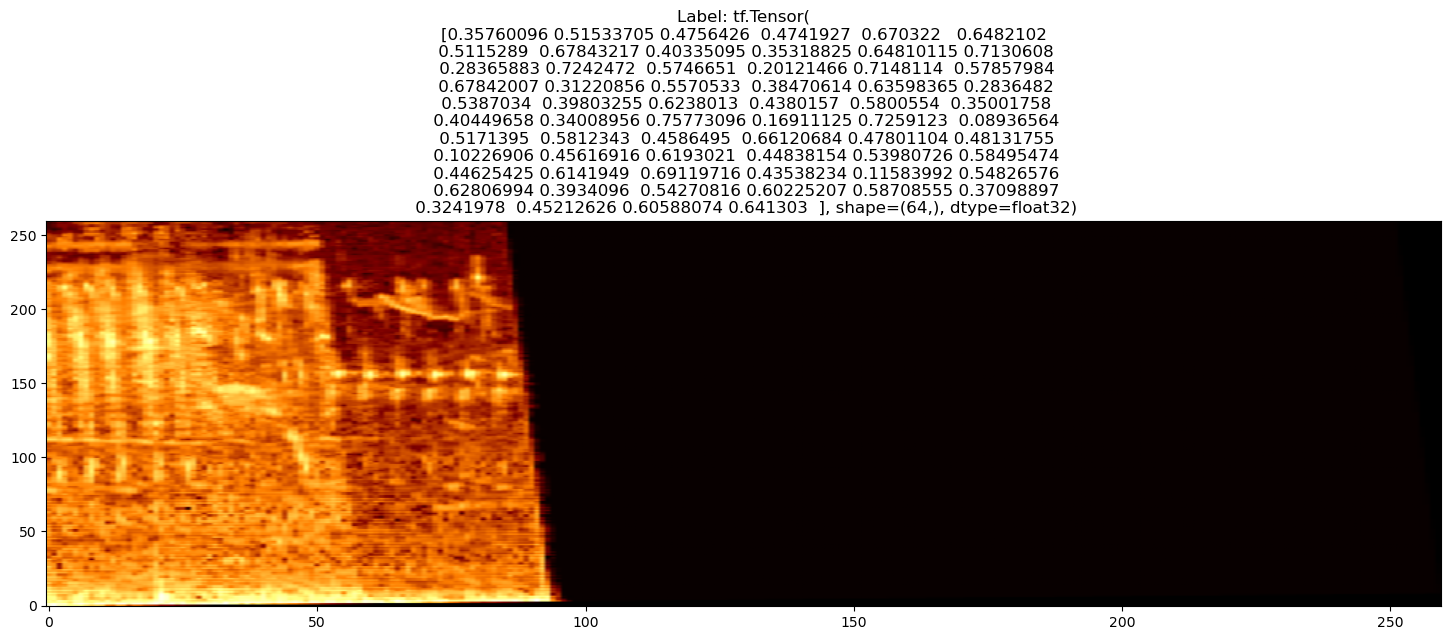

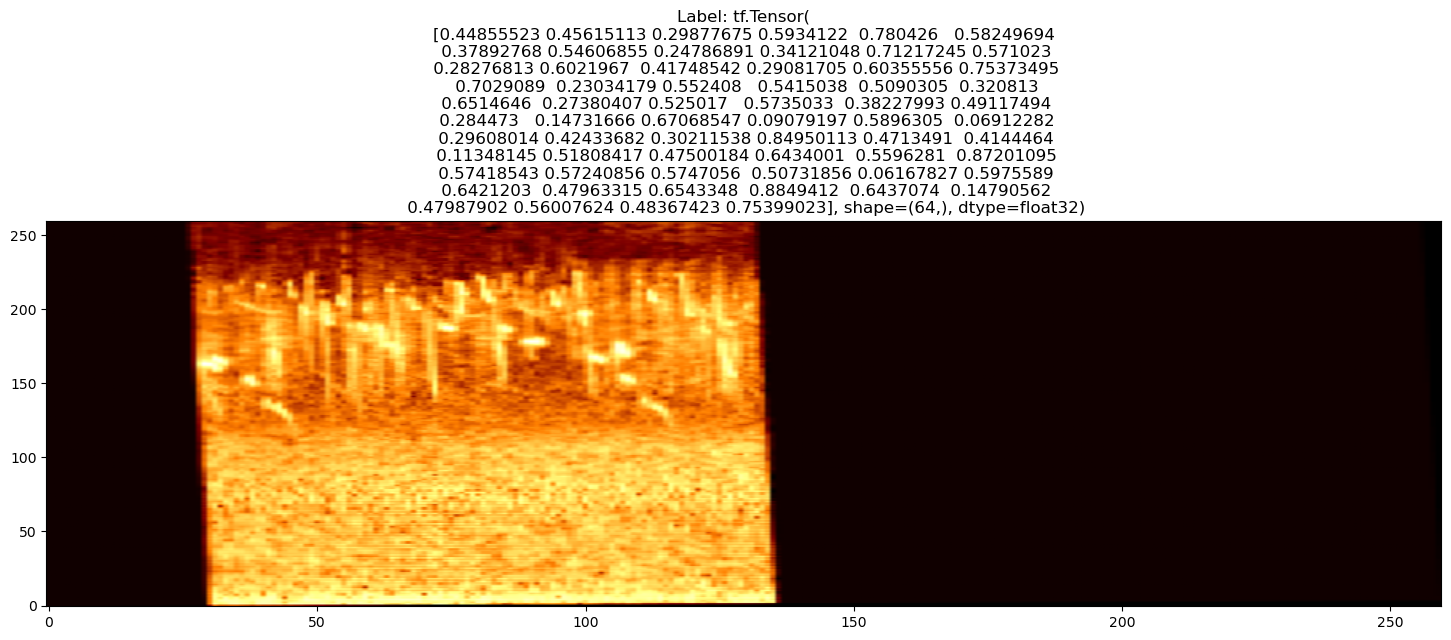

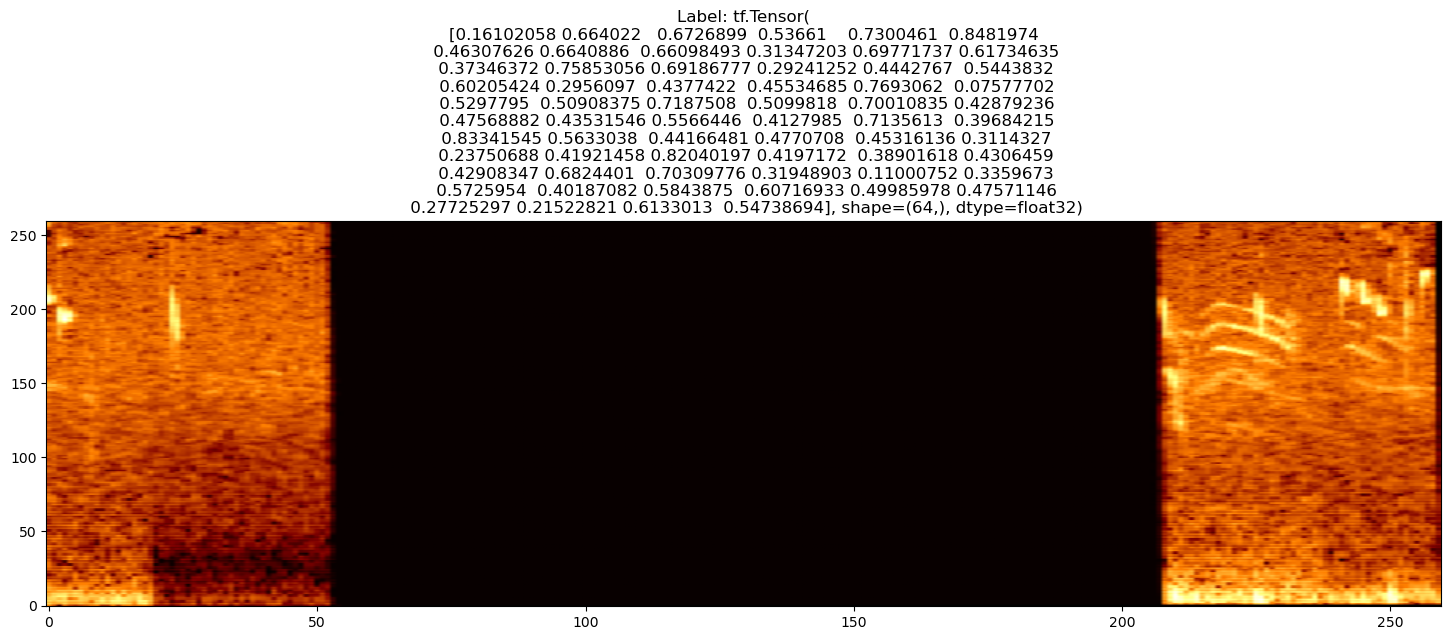

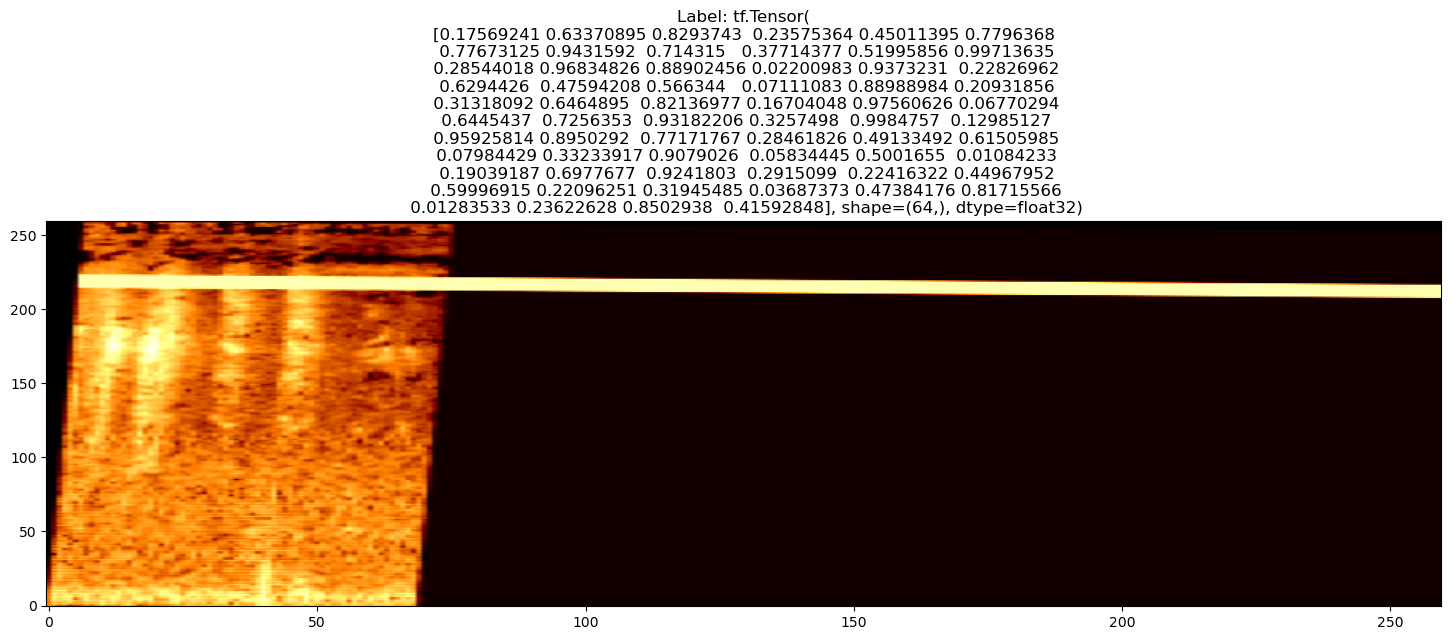

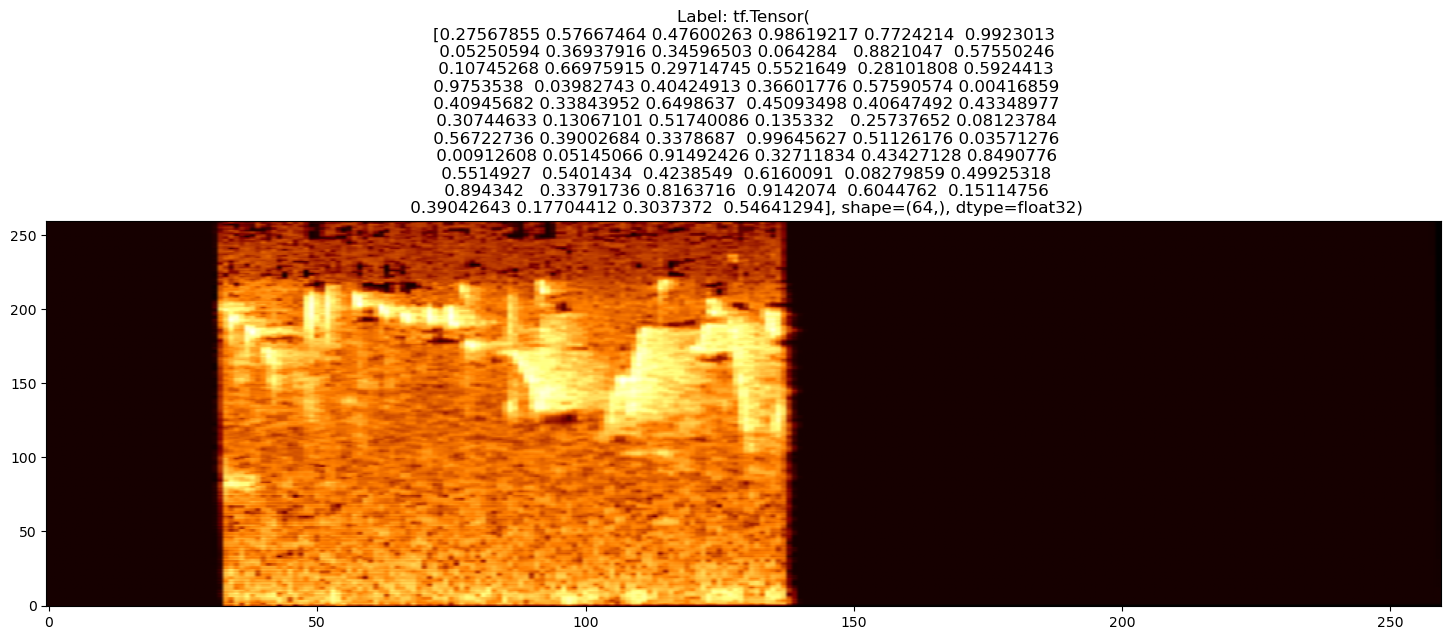

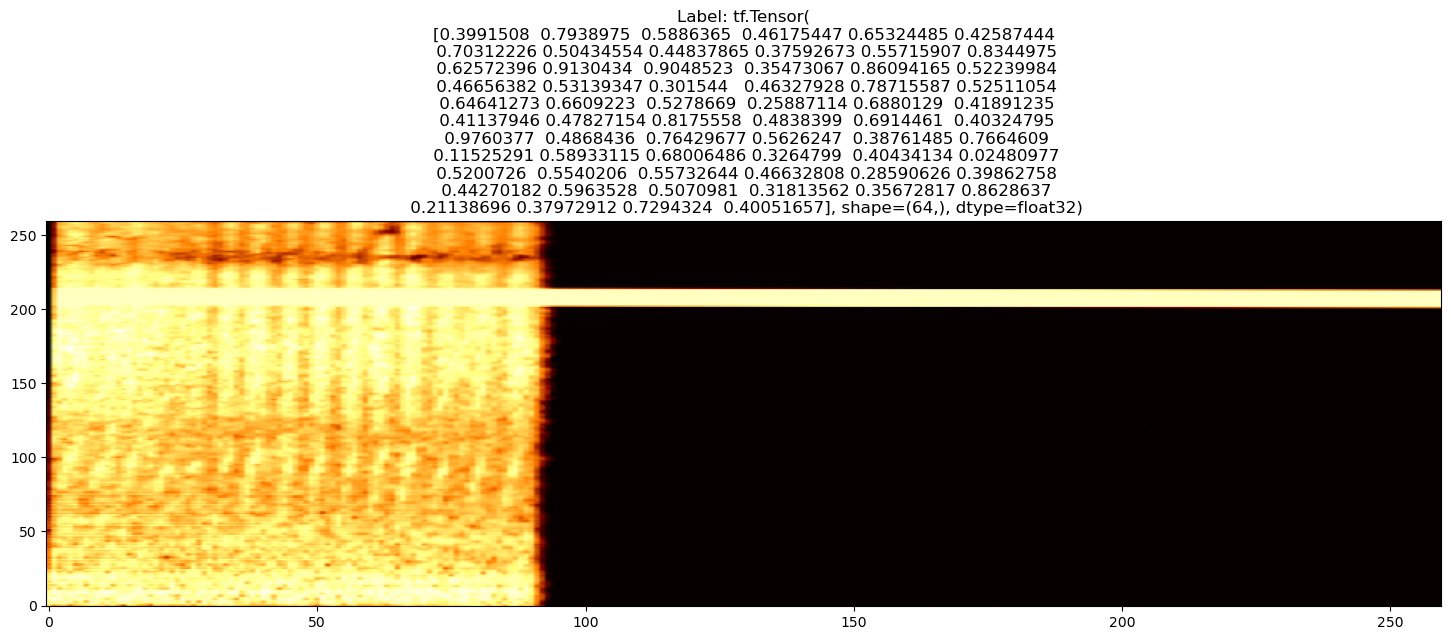

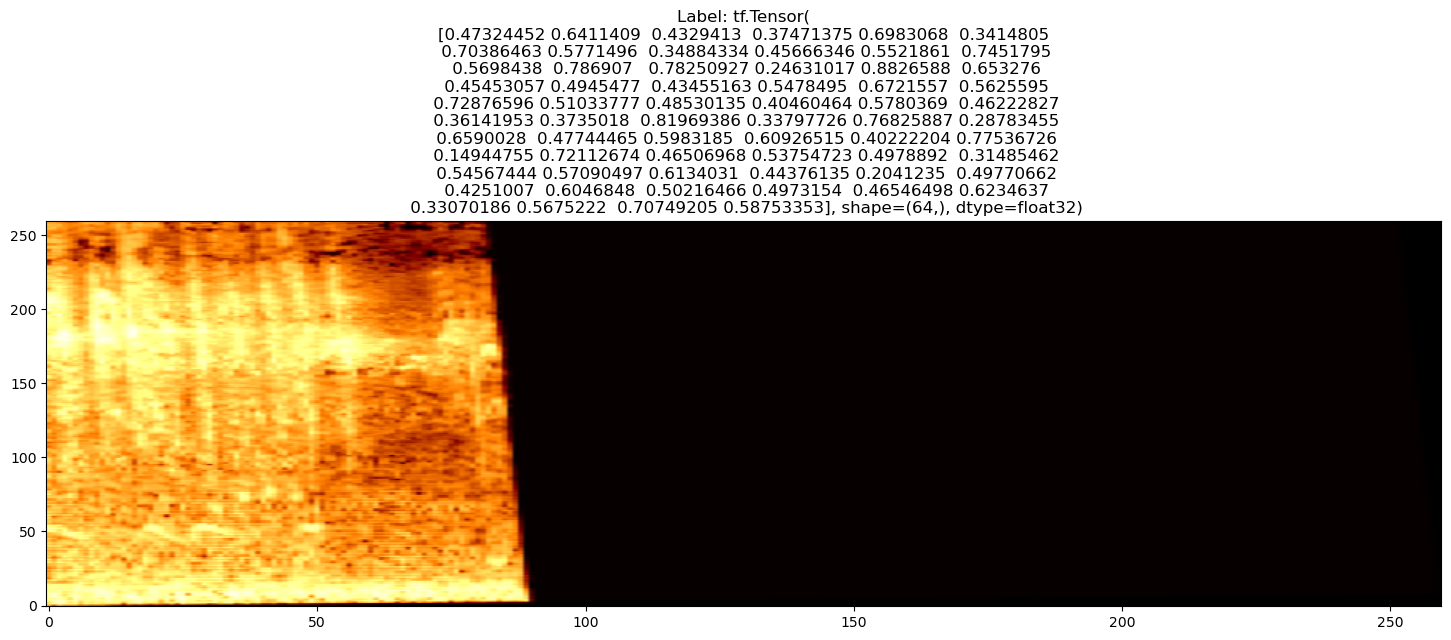

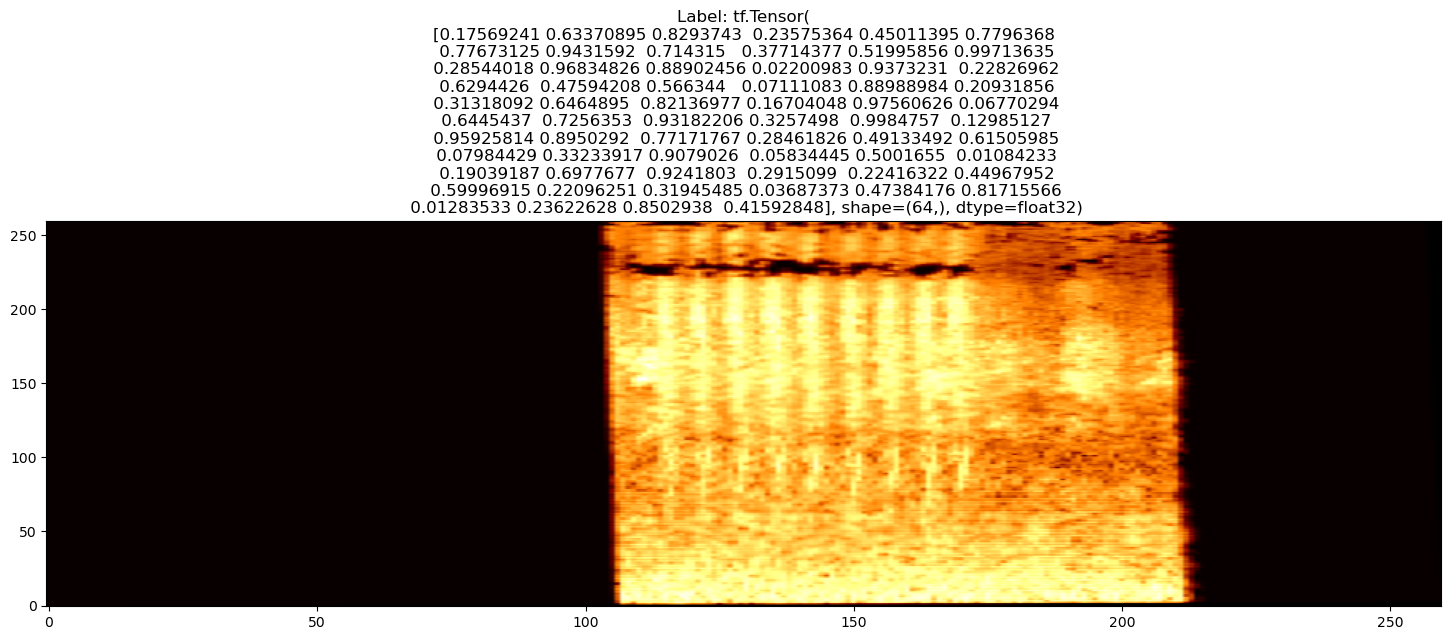

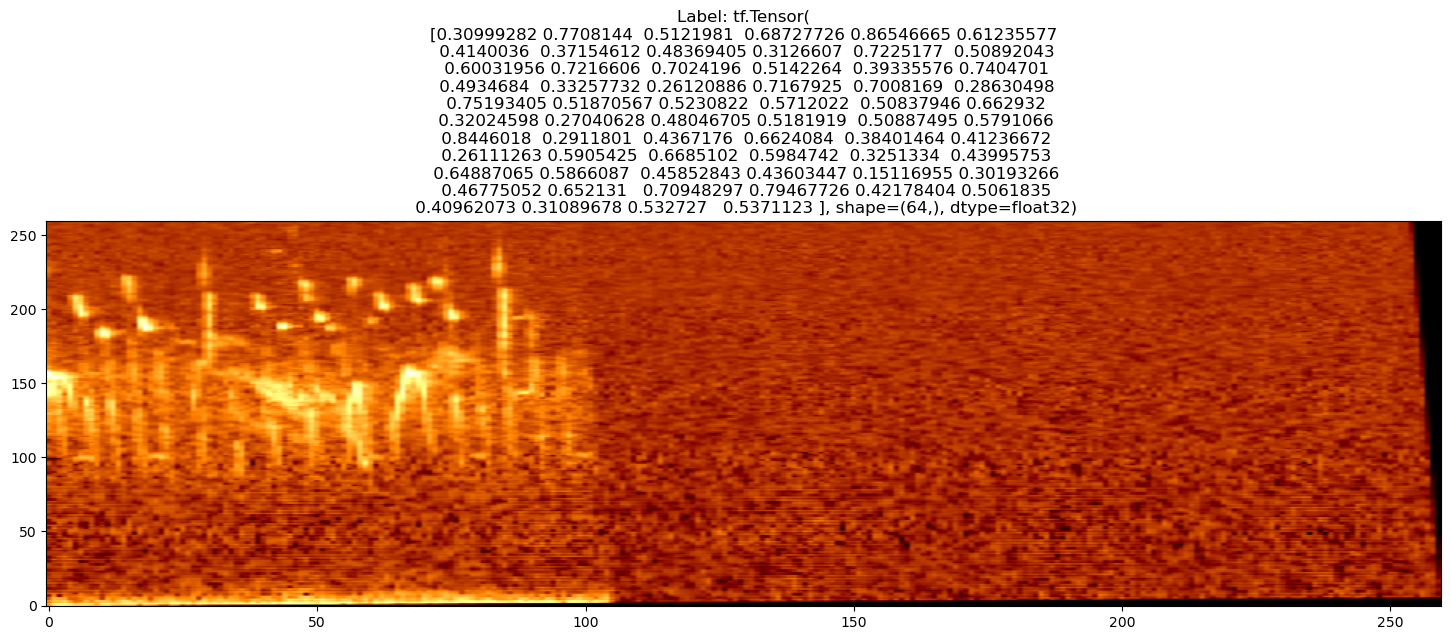

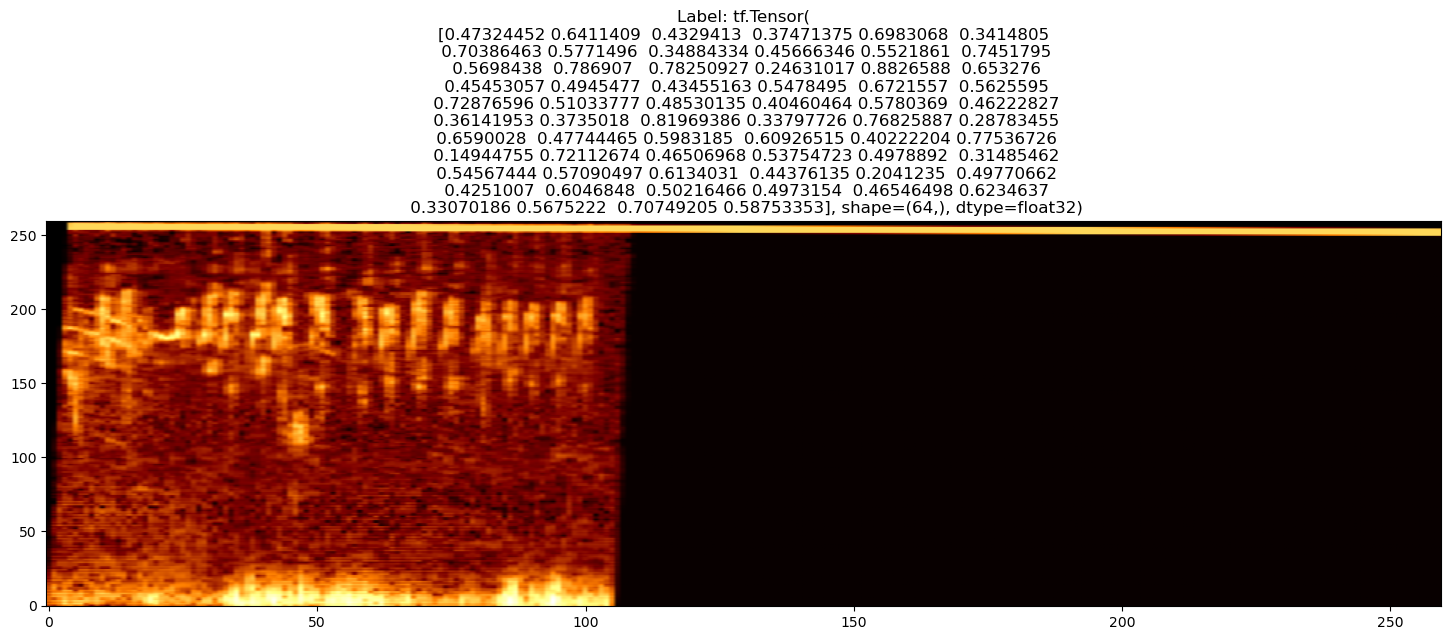

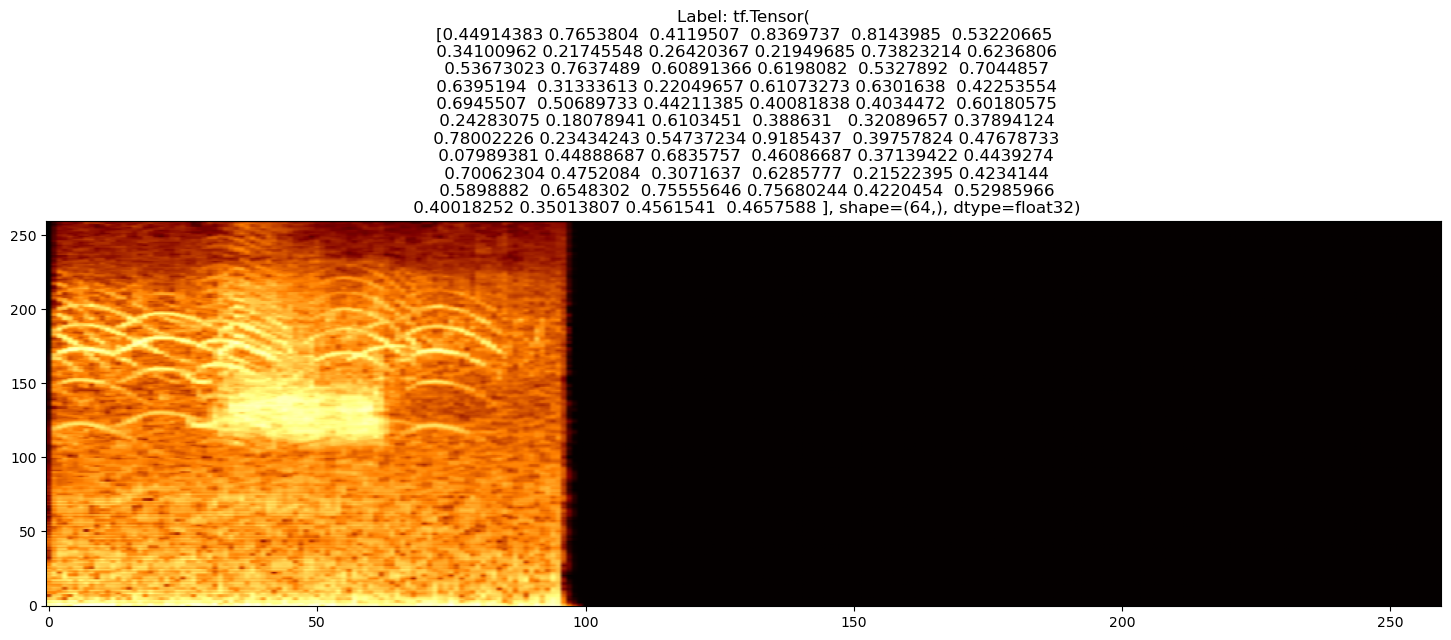

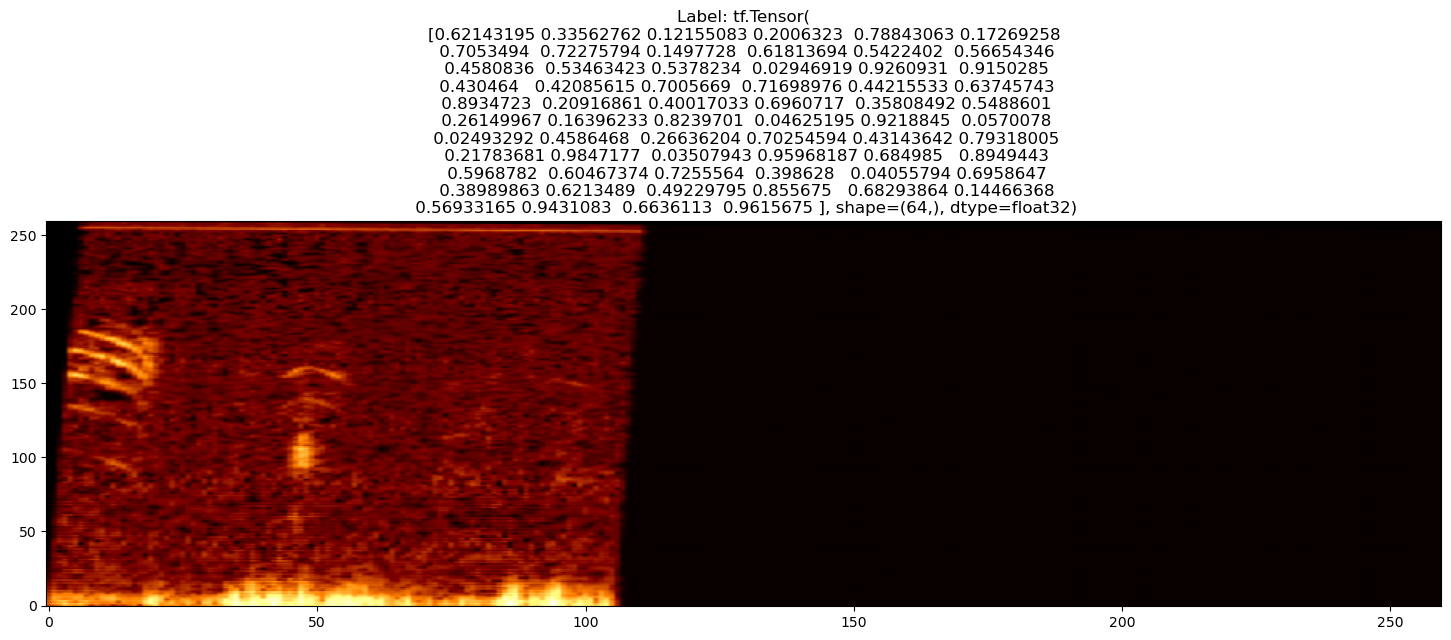

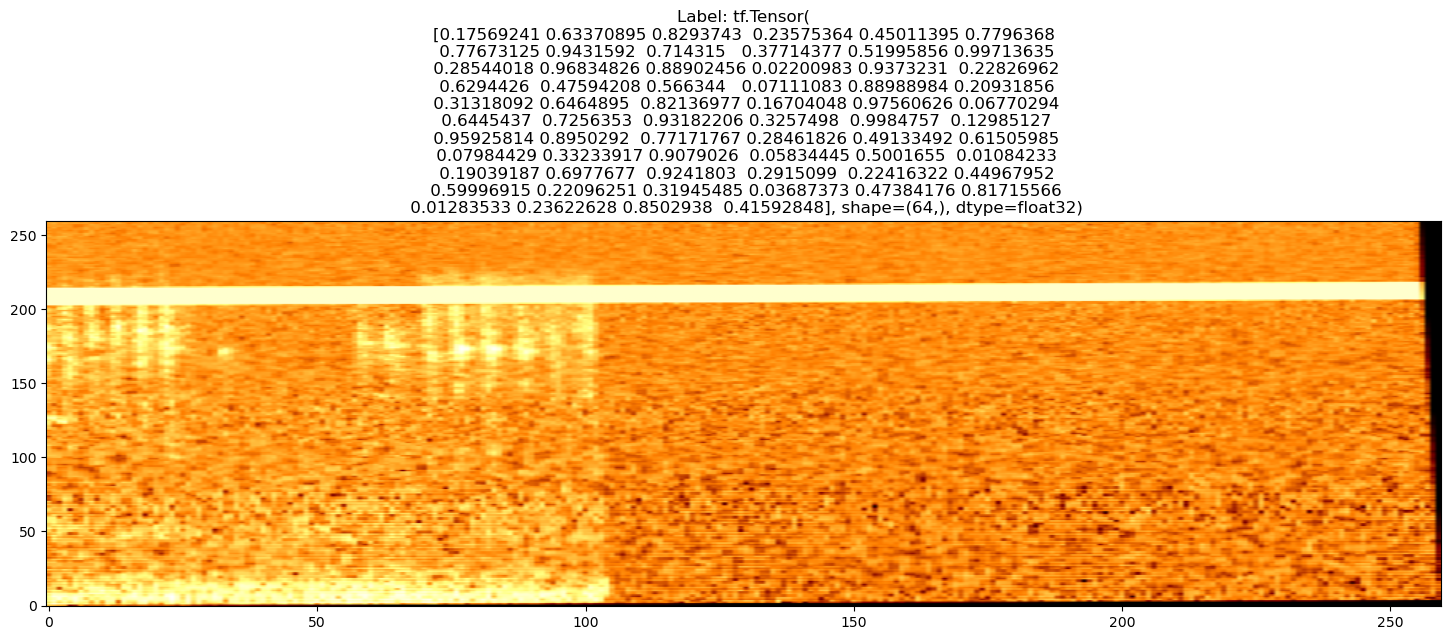

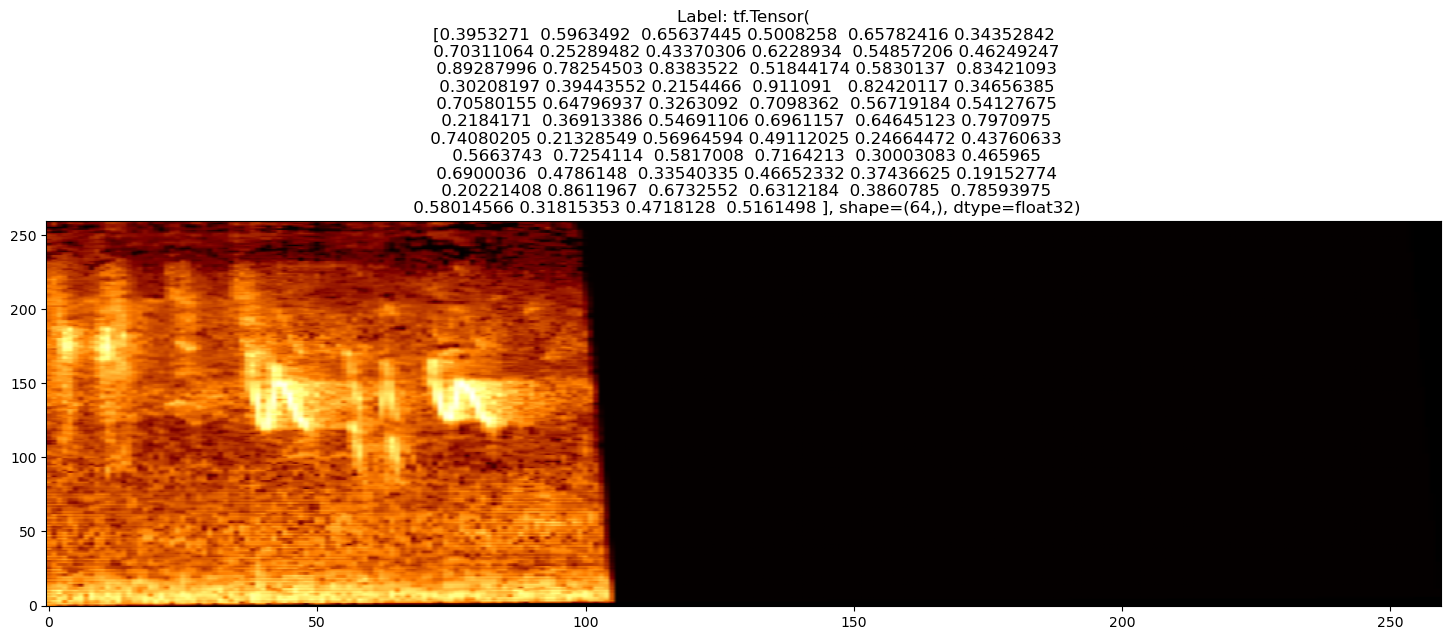

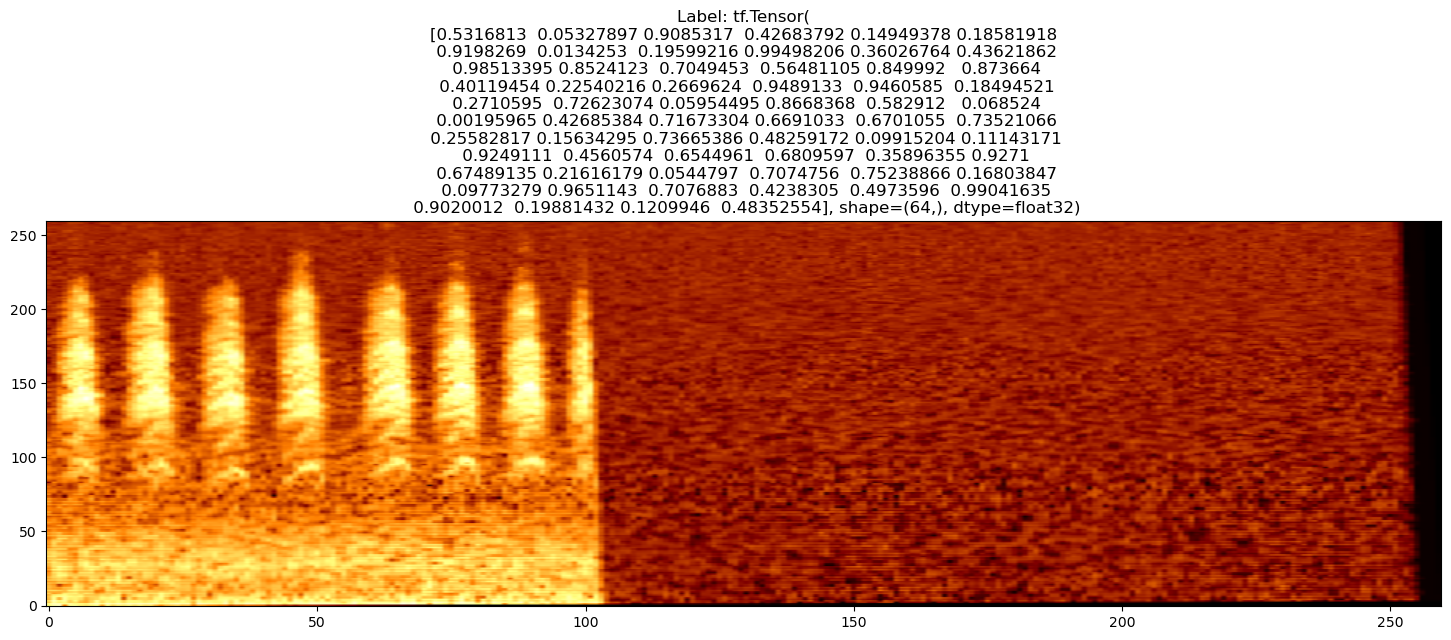

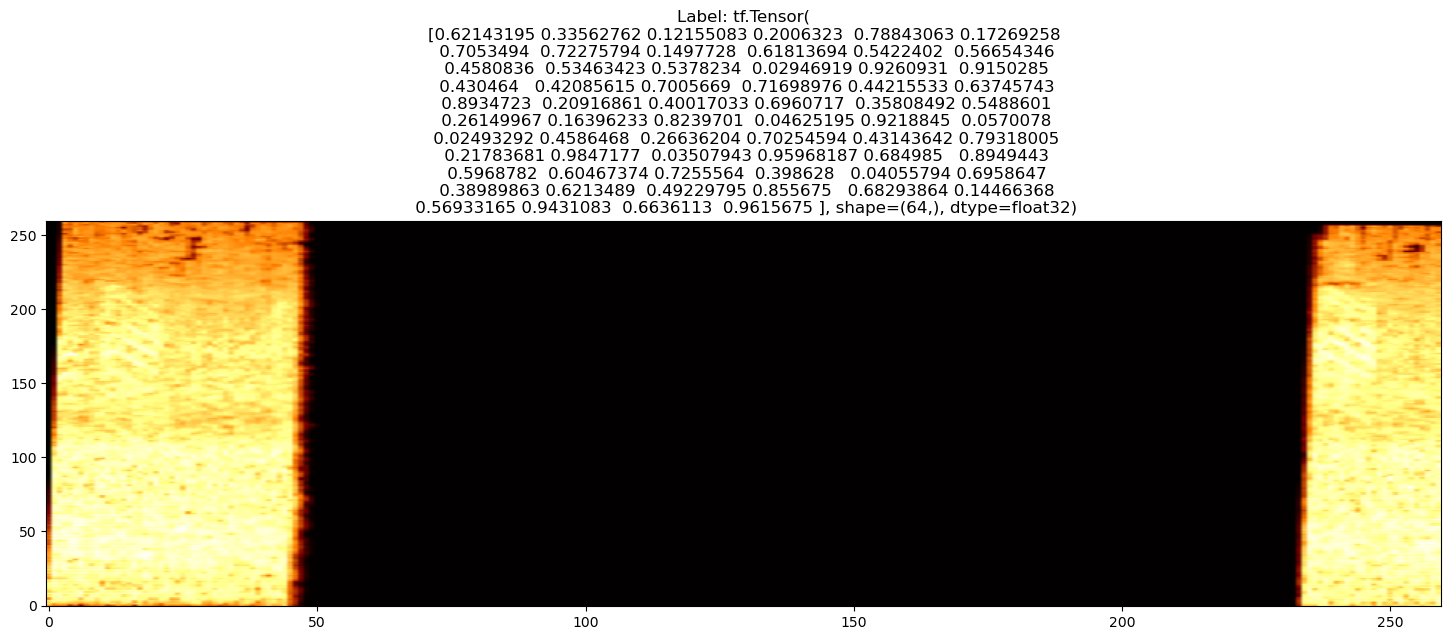

In [18]:
# show what the pipeline looks like at this stage
for melspectrogram,label in train_dataset.take(1):
    for example in range(melspectrogram.shape[0]):
        plt.figure(figsize=(18,5))
        plt.imshow(melspectrogram[example,:,:,0].numpy().T, cmap='afmhot', origin='lower', aspect='auto')
        plt.title('Label: ' + str(label[example,:]))
        plt.show()

In [19]:
def build_model(trainable, embedding_dim=embedding_dim):
    model = tf.keras.Sequential(
        [
            # Input layer with specified image dimensions
            tf.keras.layers.InputLayer(input_shape=(SC['MODEL_INPUT_IMAGE_HEIGHT'], 
                                                    SC['MODEL_INPUT_IMAGE_WIDTH'], 
                                                    SC['MODEL_INPUT_IMAGE_CHANNELS'])),

            # Use the EfficientNetV2 model as a feature generator (needs 260x260x3 images)
            hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2", trainable=trainable),
            # Add the classification layers
            tf.keras.layers.Flatten(),

            # Fully connected layer with multiple of the number of classes
            tf.keras.layers.Dense(len(class_names) * 8,
                                  activation="relu"),

            # Another fully connected layer with multiple of the number of classes
            tf.keras.layers.Dense(len(class_names) * 4,
                                  activation="relu"),

            # Add dropout to reduce overfitting
            tf.keras.layers.Dropout(0.50),

            # Output layer with one node per class, without activation
            tf.keras.layers.Dense(embedding_dim, activation='linear'),
        ]
    )
    # Set the input shape for the model
    model.build([None, 
                 SC['MODEL_INPUT_IMAGE_HEIGHT'],
                 SC['MODEL_INPUT_IMAGE_WIDTH'], 
                 SC['MODEL_INPUT_IMAGE_CHANNELS']])

    # Display the model summary
    model.summary()

    return model

In [20]:
print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)
    
# load the model if a save file already exists
if os.path.exists('models/1/'):
    print("Model already exists, skipping model building and training")
    pass
# If no model can be loaded build the model and save to file 
else:
    if not os.path.exists('models/'):
        os.mkdir('models/')
    if not os.path.exists('models/1'):
        os.mkdir('models/1')    
    
    model = build_model(True)
    
    model.compile( 
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
        metrics=[
            'mse',
            'mae',
            'cosine_similarity'
        ])
    
    # tensorboard for visualisation of results
    log_dir = "tensorboard_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                          histogram_freq=1)
    
    # reduce learning rate to avoid overshooting local minima
    lr_reduce_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                          factor=0.75,
                                                          patience=8, 
                                                          verbose=1,
                                                          mode='min',
                                                          cooldown=0, 
                                                          min_lr=1e-7)
    
    # end the training if no improvement for 10 epochs in a row, then restore best model weights
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=10,
        verbose=0,
        mode="min",
        baseline=None,
        restore_best_weights=True,
    )
    
    # save the best model as it trains..
    mcp_save = tf.keras.callbacks.ModelCheckpoint('models/checkpoint_generic_model.hdf5', 
                                               save_best_only=True, 
                                               monitor='val_loss', 
                                               mode='min')
    
    
    cache.clear()
    
    # fit the model to the training set
    @tf.autograph.experimental.do_not_convert
    def train_model():
        model.fit(
            train_dataset,
            validation_data=validation_dataset,
            epochs=SC['MAX_EPOCHS'],
            callbacks=[lr_reduce_plateau, early_stopping, tensorboard_callback, mcp_save],
        )
    
    # Measure training time
    start_time = time.time()  # Start timer
    
    train_model()
    
    end_time = time.time()  # End timer
    
    # Calculate and print elapsed time
    training_time = end_time - start_time
    print(f"Model training time: {training_time:.2f} seconds")

    # Save the full model for use with tensorflow serving
    model.save('models/1/', overwrite=True)

TensorFlow version: 2.10.0
TensorFlow Hub version: 0.16.1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              5919312   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 48)                61488     
                                                                 
 dense_1 (Dense)             (None, 24)                1176      
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                1600      
                                                                

INFO:tensorflow:Assets written to: models/1/assets


INFO:tensorflow:Assets written to: models/1/assets


### Testing the Model 

The next section of this notebook will demonstrate the application of the classification model to the test dataset. The synthetic dataset used for the training and testing of this model contains a mix of original audio files and synthetic audio files. The audio file directory can be altered to include the full database when creating the synthetic dataset. Due to memory constraints, this notebook has been limited to the following six species from the Otways region:
- Acanthiza chrysorrhoa: Yellow-rumped thornbill
- Coracina novaehollandiae: Black-faced cuckooshrike
- Daphoenositta chrysoptera: Varied sittella
- Falco peregrinus: Peregrine falcon
- Stizoptera bichenovii: Double-barred finch
- Stomiopera unicolor: White-gaped honeyeater

In [21]:
# Load the saved model
model = tf.keras.models.load_model(r"C:\Project-Echo\src\Prototypes\engine\working with overlapping audio\models\1")

In [29]:
# Reload class embeddings from saved split file
with open("./saved_splits/my_split.json", "r") as f:
    saved_data = json.load(f)
    class_embeddings = {name: np.array(emb, dtype=np.float32) for name, emb in saved_data["class_embeddings"].items()}

class_names = saved_data["class_names"]
print(f"Class names: {class_names}")

# Convert to matrix for similarity comparison
embedding_matrix = np.array([class_embeddings[name] for name in class_names])

# Reload the datasets
train_ds, val_ds, test_ds, class_names, (train_labels, val_labels, test_labels) = create_datasets(
    SC['AUDIO_DATA_DIRECTORY'],
    split_file="./saved_splits/my_split.json"
)

# Prepare the test dataset
len_test_ds = len(test_ds)
test_dataset = (
    test_ds
    .map(tensorflow_add_variant_and_cache)
    .map(functools.partial(python_fuction_wrapper, python_disk_cache_start, cache_output_types))
    .map(functools.partial(python_fuction_wrapper, python_load_and_decode_file, procs_output_types))
    .map(tensorflow_load_random_subsection)
    .map(functools.partial(python_fuction_wrapper, python_dataset_melspectro_pipeline, procs_output_types))
    .map(tensorflow_reshape_image_pipeline)
    .map(functools.partial(python_fuction_wrapper, python_disk_cache_end, procs_output_types))
    .map(tensorflow_output_shape_setter)
    .map(tensorflow_drop_variant_and_cache)
    .batch(SC['CLASSIFIER_BATCH_SIZE'])
    .prefetch(tf.data.AUTOTUNE)
)

# Identify top class matches
def get_top_classes(pred_vector, threshold = 0.9):
    similarities = cosine_similarity([pred_vector], embedding_matrix)[0]
    valid_indices = np.where(similarities >= threshold)[0]
    
    # Sort those indices by descending similarity 
    sorted_indices = valid_indices[np.argsort(similarities[valid_indices])[::-1]]
    
    # Prepare list of (class_name, similarity) tuples
    top_classes = [(class_names[i], round(similarities[i], 3)) for i in sorted_indices]
    return top_classes

results = []
global_idx = 0

for features, labels in test_dataset:
    predictions = model.predict(features, verbose=0)

    for i in range(predictions.shape[0]):
        pred_vec = predictions[i]
        true_vec = test_labels[global_idx]

        true_classes = [class_names[i] for i in range(len(class_names)) if true_vec[i] == 1]
        
         # Compute cosine similarity with class embeddings
        top_classes = get_top_classes(pred_vec, threshold=0.95)
        
        # Get indices of true classes
        true_class_indices = [i for i in range(len(true_vec)) if true_vec[i] == 1]
        
        # Get corresponding class embeddings
        true_class_embeddings = [embedding_matrix[i] for i in true_class_indices]
        
        # Compute average similarity with true class embeddings
        if true_class_embeddings:
            sim_with_true = np.mean([
                cosine_similarity([pred_vec], [true_emb])[0][0]
                for true_emb in true_class_embeddings
            ])
        else:
            sim_with_true = 0.0  # or np.nan
        
        results.append({
            "predicted_top_classes": top_classes,
            "similarity_with_true_embedding": sim_with_true,
            "true_classes": true_classes
        })
        print(f"""
----------------------------------------------------
Sample {global_idx + 1}""")
        print(f"True classes: {true_classes}")
        
        print("Predicted Classes:")
        if not top_classes:
            # Find the most similar class regardless of threshold
            similarities = cosine_similarity([pred_vec], embedding_matrix)[0]
            top_index = np.argmax(similarities)
            top_class_name = class_names[top_index]
            top_similarity = similarities[top_index]
            print(f"  - {top_class_name} (sim = {top_similarity:.4f})")
        else:
            for class_name, sim_score in top_classes:
                print(f"  - {class_name} (sim = {sim_score:.4f})")
                
        print(f"Sim with true: {sim_with_true:.4f}")
        
        global_idx += 1

Class names: ['Acanthiza chrysorrhoa', 'Coracina novaehollandiae', 'Daphoenositta chrysoptera', 'Falco peregrinus', 'Stizoptera bichenovii', 'Stomiopera unicolor']
Loading dataset splits from saved file

----------------------------------------------------
Sample 1
True classes: ['Daphoenositta chrysoptera']
Predicted Classes:
  - Daphoenositta chrysoptera (sim = 0.9660)
Sim with true: 0.9656

----------------------------------------------------
Sample 2
True classes: ['Falco peregrinus']
Predicted Classes:
  - Falco peregrinus (sim = 0.9940)
Sim with true: 0.9937

----------------------------------------------------
Sample 3
True classes: ['Stomiopera unicolor']
Predicted Classes:
  - Stomiopera unicolor (sim = 0.9830)
Sim with true: 0.9826

----------------------------------------------------
Sample 4
True classes: ['Stomiopera unicolor']
Predicted Classes:
  - Stomiopera unicolor (sim = 0.9790)
Sim with true: 0.9795

----------------------------------------------------
Sample 5
True